In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:4")
    print(f"Device: {device}")


/home/chenh/.conda/envs/advTexture/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda:4


In [3]:
import numpy as np 
import scipy.io as sio
import torch
import os 
import tqdm

import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader,random_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from Utils import *
from Models import *

torch.manual_seed(1234)
np.random.seed(1234)

import warnings
warnings.simplefilter("ignore")

2024-01-17 09:04:00.070124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 09:04:00.447478: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 09:04:01.550018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-17 09:04:01.550306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [4]:
Mean_Images = sio.loadmat("Sample Data/images.mat")["img"] #corresponding to the images mean for all the seven windows
print(np.shape(Mean_Images)) 
Images = sio.loadmat("Sample Data/images_time.mat")["img"] #corresponding to the images mean for all the seven windows
print(np.shape(Images)) 
Label = (sio.loadmat("Sample Data/FeatureMat_timeWin")["features"][:,-1]-1).astype(int) #corresponding to the signal label (i.e. load levels). 0,1,2,3
print(np.shape(Label)) 
Patient_id = sio.loadmat("Sample Data/trials_subNums.mat")['subjectNum'][0] #corresponding to the patient id
print(np.shape(Patient_id))

(2670, 3, 32, 32)
(7, 2670, 3, 32, 32)
(2670,)
(2670,)


In [5]:
print("Choose among the patient : "+str(np.unique(Patient_id)))

Choose among the patient : [ 1  2  3  4  6  7  8  9 10 11 12 14 15]


In [6]:
choosen_patient = 6

In [7]:
train_part = 0.8
test_part = 0.2

batch_size = 32

n_epoch = 30
n_rep = 20  # 记录20次重复实验的结果

In [8]:

def Confusion_Test_Model(net, Testloader, criterion, is_cuda=True):
    running_loss = 0.0 
    evaluation = []
    predicted_label = []
    true_label = []
    for i, data in enumerate(Testloader, 0):
        input_img, labels = data
        input_img = input_img.to(torch.float32)
        if is_cuda:
            input_img = input_img.cuda()
        outputs = net(input_img)
        _, predicted = torch.max(outputs.cpu().data, 1)
        predicted_label += predicted.cpu().data.tolist()
        true_label += labels.tolist()
        evaluation.append((predicted==labels).tolist())
        loss = criterion(outputs, labels.cuda())
        running_loss += loss.item()
    running_loss = running_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    running_acc = sum(evaluation)/len(evaluation)
    return running_loss, running_acc, predicted_label, true_label

In [9]:
def Confusion_Train_Model(model, trainloader, testloader, n_epoch=30, opti='SGD', learning_rate=0.0001, is_cuda=True, print_epoch =5, verbose=False):
    if is_cuda:
        net = model().cuda()
    else :
        net = model()
        
    criterion = nn.CrossEntropyLoss()
    
    if opti=='SGD':
        optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    elif opti =='Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    else: 
        print("Optimizer: "+optim+" not implemented.")


    predicted_label = []
    true_label = []
    max_acc = 0    
    for epoch in tqdm.tqdm(range(n_epoch)):
        running_loss = 0.0
        evaluation = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(torch.float32).cuda())  # (batch_size, 4)
            _, predicted = torch.max(outputs.cpu().data, 1) # 取出4个类别中最大概率对应的索引
            evaluation.append((predicted==labels).tolist())
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss = running_loss/(i+1)
        evaluation = [item for sublist in evaluation for item in sublist]
        running_acc = sum(evaluation)/len(evaluation)
        validation_loss, validation_acc, predicted_, true_ = Confusion_Test_Model(net, testloader, criterion,True)
        if validation_acc > max_acc:
            max_acc = validation_acc
            predicted_label = predicted_
            true_label = true_


        if epoch%print_epoch==(print_epoch-1):
            print('[%d, %3d]\tloss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
    
    return (running_loss, running_acc, validation_loss,validation_acc), predicted_label, true_label

In [10]:
print("\n\n\n\n Temp CNN \n\n\n\n")

Predict_Label = []
True_Label = []
Result = []
for r in range(n_rep):
    label = Label[Patient_id == choosen_patient]    # (185,)
    image = Images[:, Patient_id == choosen_patient, :, :]  # (7,185,3,32,32)
    image = np.transpose(image, (1, 0, 2, 3, 4))  # (185,7,3,32,32)
    EEG = EEGImagesDataset(label=label, image=image)
    lengths = [int(len(EEG) * train_part + 1), int(len(EEG) * test_part)]
    if sum(lengths) < len(EEG):
        lengths[0] = lengths[0] + 1
    if sum(lengths) > len(EEG):
        lengths[0] = lengths[0] - 1
    Train, Test = random_split(EEG, lengths)
    Trainloader = DataLoader(Train, batch_size=batch_size)
    Testloader = DataLoader(Test, batch_size=batch_size)
    res, predicted_, true_ = Confusion_Train_Model(TempCNN, Trainloader, Testloader, n_epoch=n_epoch, learning_rate=0.001, print_epoch=-1,
                            opti='Adam')
    Result.append(res)
    Predict_Label.append(predicted_)
    True_Label.append(true_)
    





 Temp CNN 






100%|██████████| 30/30 [01:23<00:00,  2.77s/it]


In [11]:
for i in range(len(Result)):
    print(Result[i][3])

print("Mean Accuracy: "+str(np.mean([Result[i][3] for i in range(len(Result))])))

0.9743589743589743
0.9487179487179487
0.9230769230769231
0.9743589743589743
0.8974358974358975
0.9743589743589743
0.9743589743589743
1.0
0.9487179487179487
1.0
0.9743589743589743
0.9743589743589743
0.8717948717948718
0.9487179487179487
1.0
0.9487179487179487
0.9743589743589743
1.0
0.9743589743589743
0.9487179487179487
Mean Accuracy: 0.9615384615384615


The largest accuracy is:  1.0
The corresponding confusion matrix is: [[16  0  0  0]
 [ 0 10  0  0]
 [ 0  0 11  0]
 [ 0  0  0  2]]
The second largest accuracy is:  0.9743589743589743
The third largest accuracy is:  0.9487179487179487


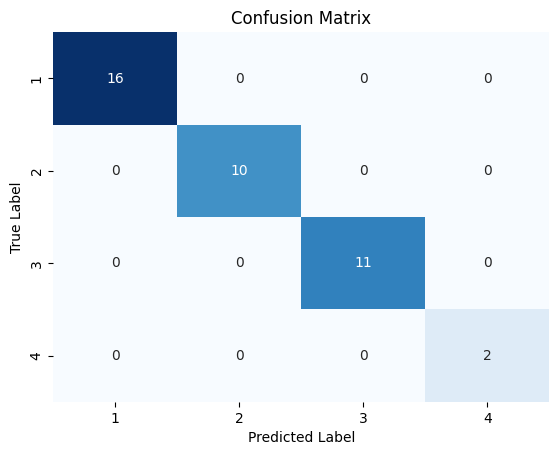

In [12]:
# find the largest accuracy among the 20 times
max_acc = 0
for i in range(len(Result)):
    if Result[i][3] > max_acc:
        max_acc = Result[i][3]
        max_index = i
print("The largest accuracy is: ", max_acc)
# 计算混淆矩阵
cm = confusion_matrix(True_Label[max_index], Predict_Label[max_index])
print(f"The corresponding confusion matrix is: {cm}")
# 可视化混淆矩阵
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# 保存混淆矩阵为图片文件
plt.savefig('ConfusionMatrix.png', dpi=400)

# find the second largest accuracy among the 20 times
second_max_acc = 0
for i in range(len(Result)):
    if Result[i][3] > second_max_acc and Result[i][3] < max_acc:
        second_max_acc = Result[i][3]
        second_max_index = i
print("The second largest accuracy is: ", second_max_acc)
# # 计算混淆矩阵
# sec_cm = confusion_matrix(True_Label[second_max_index], Predict_Label[second_max_index])
# print(f"The corresponding confusion matrix is: {sec_cm}")
# # 可视化混淆矩阵
# sns.heatmap(sec_cm, annot=True, cmap="Blues", fmt="d", cbar=False,
#             xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# # 保存混淆矩阵为图片文件
# plt.savefig('ConfusionMatrix.png', dpi=400)

# find the third largest accuracy among the 20 times
third_max_acc = 0
for i in range(len(Result)):
    if Result[i][3] > third_max_acc and Result[i][3] < second_max_acc:
        third_max_acc = Result[i][3]
        third_max_index = i
print("The third largest accuracy is: ", third_max_acc)
# # 计算混淆矩阵
# third_cm = confusion_matrix(True_Label[third_max_index], Predict_Label[third_max_index])
# print(f"The corresponding confusion matrix is: {third_cm}")
# # 可视化混淆矩阵
# sns.heatmap(third_cm, annot=True, cmap="Blues", fmt="d", cbar=False,
#             xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# # 保存混淆矩阵为图片文件
# plt.savefig('ConfusionMatrix.png', dpi=400)

# # find the forth largest accuracy among the 20 times
# forth_max_acc = 0
# for i in range(len(Result)):
#     if Result[i][3] > forth_max_acc and Result[i][3] < third_max_acc:
#         forth_max_acc = Result[i][3]
#         forth_max_index = i
# print("The forth largest accuracy is: ", forth_max_acc)
# # 计算混淆矩阵
# third_cm = confusion_matrix(True_Label[forth_max_index], Predict_Label[forth_max_index])
# print(f"The corresponding confusion matrix is:\n {third_cm}")
# # 可视化混淆矩阵
# sns.heatmap(third_cm, annot=True, cmap="Blues", fmt="d", cbar=False,
#             xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# # 保存混淆矩阵为图片文件
# plt.savefig('ConfusionMatrix.png', dpi=400)

